In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Layer
from sklearn.preprocessing import StandardScaler

/Users/Nozha/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-03-16 10:06:23.226473: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
df = pd.read_csv('eurusd.csv', sep = ';',names=['date', 'time', 'open','high','low','close','volume'])
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'eurusd.csv'

In [48]:
df.shape

(1620750, 7)

In [1]:
df[df.date=='06/02/2018']

NameError: name 'df' is not defined

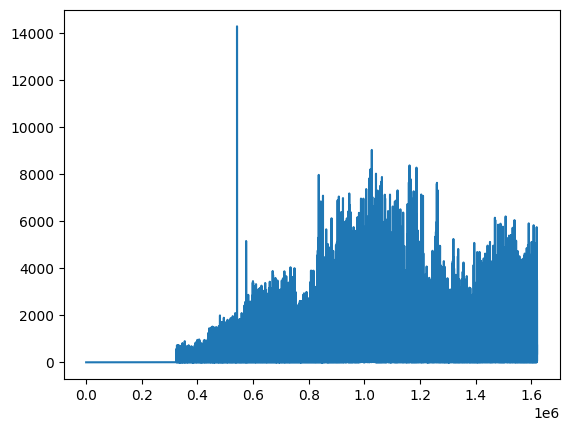

In [55]:
import matplotlib.pyplot as plt
plt.plot(df.volume)

In [57]:
df.volume.min()

0

In [58]:
df.volume.max()

14306

In [63]:
df.to_csv('eurusd_5m.csv', index=False) 

In [7]:
# define monthly window for technical indicators (rolling average and volatility)
timeframe=30
df['sma']=df['close'].rolling(timeframe).mean()
df['ema'] = df['close'].ewm(span=4,min_periods=timeframe, adjust=False).mean()
df['vola']=df['close'].rolling(timeframe).std()

In [8]:
# drop first month rows with NANs
df = df.iloc[timeframe-1:]
df.head()

,date,open,high,low,close,adj close,volume,return,dir,sma,ema,vola
29,2010-04-26,31.000000,31.280001,30.860001,31.110001,23.662863,63649300,0.150002,1,30.087333,31.122228,0.730644
30,2010-04-27,30.950001,31.250000,30.750000,30.850000,23.465101,68730900,-0.260001,0,30.139333,31.013337,0.727447
31,2010-04-28,30.920000,31.000000,30.620001,30.910000,23.510729,64557900,0.060000,1,30.190667,30.972002,0.725620
32,2010-04-29,30.930000,31.430000,30.670000,31.000000,23.579191,52665200,0.090000,1,30.236333,30.983201,0.732198
33,2010-04-30,31.070000,31.080000,30.520000,30.540001,23.229317,63214800,-0.459999,0,30.267333,30.805921,0.724412


In [9]:
df=df.reset_index(drop=True)
df.head()

,date,open,high,low,close,adj close,volume,return,dir,sma,ema,vola
0,2010-04-26,31.000000,31.280001,30.860001,31.110001,23.662863,63649300,0.150002,1,30.087333,31.122228,0.730644
1,2010-04-27,30.950001,31.250000,30.750000,30.850000,23.465101,68730900,-0.260001,0,30.139333,31.013337,0.727447
2,2010-04-28,30.920000,31.000000,30.620001,30.910000,23.510729,64557900,0.060000,1,30.190667,30.972002,0.725620
3,2010-04-29,30.930000,31.430000,30.670000,31.000000,23.579191,52665200,0.090000,1,30.236333,30.983201,0.732198
4,2010-04-30,31.070000,31.080000,30.520000,30.540001,23.229317,63214800,-0.459999,0,30.267333,30.805921,0.724412


In [10]:
input_data= df[['close','return','ema','vola','volume']]
targets=df['dir'].values
T=5
D=input_data.shape[1]
N=len(input_data)-T
D,N

(5, 3490)

In [11]:
input_data.head()

,close,return,ema,vola,volume
0,31.110001,0.150002,31.122228,0.730644,63649300
1,30.850000,-0.260001,31.013337,0.727447,68730900
2,30.910000,0.060000,30.972002,0.725620,64557900
3,31.000000,0.090000,30.983201,0.732198,52665200
4,30.540001,-0.459999,30.805921,0.724412,63214800


In [12]:
Ntrain=int(len(input_data)*0.8)
Ntrain

2796

In [13]:
scaler=StandardScaler()
scaler.fit(input_data[:Ntrain+T])
input_data_scaled=scaler.transform(input_data)
input_data_scaled

input_scaled= pd.DataFrame(input_data_scaled, index=input_data.index, columns=input_data.columns)
input_scaled.head()

,close,return,ema,vola,volume
0,-0.751351,0.038975,-0.751017,-0.597749,1.135787
1,-0.755648,-0.187627,-0.752821,-0.599058,1.367511
2,-0.754657,-0.010768,-0.753506,-0.599807,1.177220
3,-0.753169,0.005813,-0.753320,-0.597113,0.634907
4,-0.760771,-0.298162,-0.756257,-0.600302,1.115974


In [14]:
X_train=np.zeros((Ntrain,T,D))
y_train=np.zeros(Ntrain)


In [15]:
for t in range(Ntrain):
    X_train[t, :, :]=input_data_scaled[t:t+T]
    y_train[t]=(targets[t+T])

X_train.shape, y_train.shape


((2796, 5, 5), (2796,))

In [16]:
X_test=np.zeros((N-Ntrain,T,D))
y_test=np.zeros(N-Ntrain)

for u in range(N- Ntrain):
    t= u + Ntrain
    X_test[u, :, :]=input_data[t:t+T]
    y_test[u]=(targets[t+T])
    
X_test.shape, y_test.shape

((694, 5, 5), (694,))

In [17]:
T = 5
D = input_data.shape[1]
model=Sequential()
model.add(LSTM(64, input_shape=(T, D)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

/Users/Nozha/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
    loss='binary_crossentropy',
    optimizer= 'Adam',
    metrics=['accuracy']
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
# pip install --upgrade tensorflow

In [21]:
#from tensorflow.keras.callbacks import EarlyStopping

#es = EarlyStopping(patience=5, restore_best_weights=True)
#callbacks=[es],

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size=32, 
                    epochs=10, 
                    verbose=1)

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4955 - loss: 0.6935 - val_accuracy: 0.5536 - val_loss: 0.6913
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5176 - loss: 0.6918 - val_accuracy: 0.5411 - val_loss: 0.6882
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5151 - loss: 0.6918 - val_accuracy: 0.5536 - val_loss: 0.6942
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5142 - loss: 0.6917 - val_accuracy: 0.5536 - val_loss: 0.7085
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5216 - loss: 0.6917 - val_accuracy: 0.5482 - val_loss: 0.7151
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5380 - loss: 0.6898 - val_accuracy: 0.5482 - val_loss: 0.7169
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5294 - loss: 0.6888 - val_accuracy: 0.5536 - val_loss: 0.7392
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5143 - loss: 0.6921 - val_accuracy: 0.5571 - val_loss:

In [22]:
pred=model.predict(X_test)
pred

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([[0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.19038908],
       [0.190

In [23]:
X_test

array([[[ 2.45710007e+02, -1.58999600e+00,  2.47202075e+02,
          5.55726434e+00,  2.53077000e+07],
        [ 2.50789993e+02,  5.07998600e+00,  2.48637242e+02,
          5.37864964e+00,  2.52811000e+07],
        [ 2.53809998e+02,  3.02000500e+00,  2.50706345e+02,
          4.97947558e+00,  2.30792000e+07],
        [ 2.52570007e+02, -1.23999100e+00,  2.51451810e+02,
          4.45290006e+00,  2.24550000e+07],
        [ 2.53589996e+02,  1.01998900e+00,  2.52307084e+02,
          3.82230084e+00,  1.79376000e+07]],

       [[ 2.50789993e+02,  5.07998600e+00,  2.48637242e+02,
          5.37864964e+00,  2.52811000e+07],
        [ 2.53809998e+02,  3.02000500e+00,  2.50706345e+02,
          4.97947558e+00,  2.30792000e+07],
        [ 2.52570007e+02, -1.23999100e+00,  2.51451810e+02,
          4.45290006e+00,  2.24550000e+07],
        [ 2.53589996e+02,  1.01998900e+00,  2.52307084e+02,
          3.82230084e+00,  1.79376000e+07],
        [ 2.57239990e+02,  3.64999400e+00,  2.54280246e+02,
  

In [24]:
# resultsTest = model.evaluate(pred, y_test)
# print("RESULT ACCURACY = ", resultsTest)

In [25]:
y_test.shape

(694,)

In [26]:
pred.reshape((694,)

SyntaxError: incomplete input (2840155246.py, line 1)

In [ ]:
diff=y_test-pred
diff.shape

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
len(diff)

In [ ]:
len(np.where( diff <0.5))

In [ ]:
diff.shape